In [16]:
# NLP Homework 1

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
from torch.utils.data import DataLoader, Dataset
import time
import os

#Simulate self attention and profile its cost. measure complexity with FLOPS, memory, and wall clock time.

# simulate self attention input with lengths 10, 100, 1000, 10000
lengths = [10, 100, 1000, 10000]

d_model = 128 
n_runs = 10

torch.manual_seed(123)
embeddings = [torch.randn(l, d_model) for l in lengths]

print(embeddings[0].shape)

torch.Size([10, 128])


In [17]:
# simulate self attention
def self_attention(x, device):
    # x: (seq_len, d_model)
    seq_len, d_model = x.shape
    # initialize weight matrices
    W_Q = torch.randn(d_model, d_model).to(device)
    W_K = torch.randn(d_model, d_model).to(device)
    W_V = torch.randn(d_model, d_model).to(device)
    # Compute Q, K, V
    Q = torch.matmul(x, W_Q)  # (seq_len, d_model)
    K = torch.matmul(x, W_K)  # (seq_len, d_model)
    V = torch.matmul(x, W_V)  # (seq_len, d_model)

    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(0, 1)) / math.sqrt(d_model)  # (seq_len, seq_len)

    # Apply softmax to get attention weights
    attn_weights = F.softmax(scores, dim=-1)  # (seq_len, seq_len)

    # Compute the output
    output = torch.matmul(attn_weights, V)  # (seq_len, d_model)

    return output
# Profile the cost for GPU and CPU
def profile_attention(x, device):
    x = x.to(device)
    torch.mps.synchronize() if device.type == 'mps' else None
    start_time = time.time()
    output = self_attention(x, device)
    torch.mps.synchronize() if device.type == 'mps' else None
    end_time = time.time()
    wall_clock_time = end_time - start_time
    seq_len, d_model = x.shape
    flops = 3 * seq_len  * d_model * d_model + 2 * seq_len * seq_len * d_model
    memory = 4 * (x.numel() + 3 * seq_len * d_model + 3 * d_model * d_model + 2 * seq_len**2 + seq_len * d_model)

    return flops, memory, wall_clock_time

devices = [torch.device('cpu'), torch.device('mps')]

# run profiling, store results in lists return list for each device
results = {device.type: [] for device in devices}
for device in devices:
    for emb in embeddings:
        run_results = []
        for n in range(n_runs):
            flops, memory, wall_clock_time = profile_attention(emb, device)
            run_results.append((flops, memory, wall_clock_time))
            print(f"Device: {device}, Length: {emb.shape[0]}, FLOPS: {flops}, Memory: {memory}, Time: {wall_clock_time:.6f} seconds")
        results[device.type].append(run_results)

        


Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.001593 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.001514 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.001095 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.000798 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.000532 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.000537 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.000531 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.001098 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.001964 seconds
Device: cpu, Length: 10, FLOPS: 517120, Memory: 223008, Time: 0.000620 seconds
Device: cpu, Length: 100, FLOPS: 7475200, Memory: 532608, Time: 0.015284 seconds
Device: cpu, Length: 100, FLOPS: 7475200, Memory: 532608, Time: 0.013957 seconds
Device: cpu, Length: 100, FLOPS: 7475200, Memory

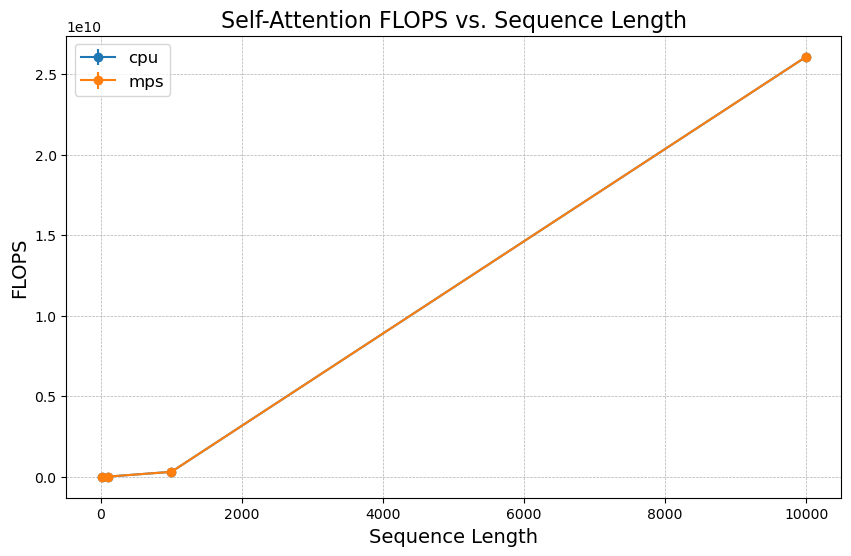

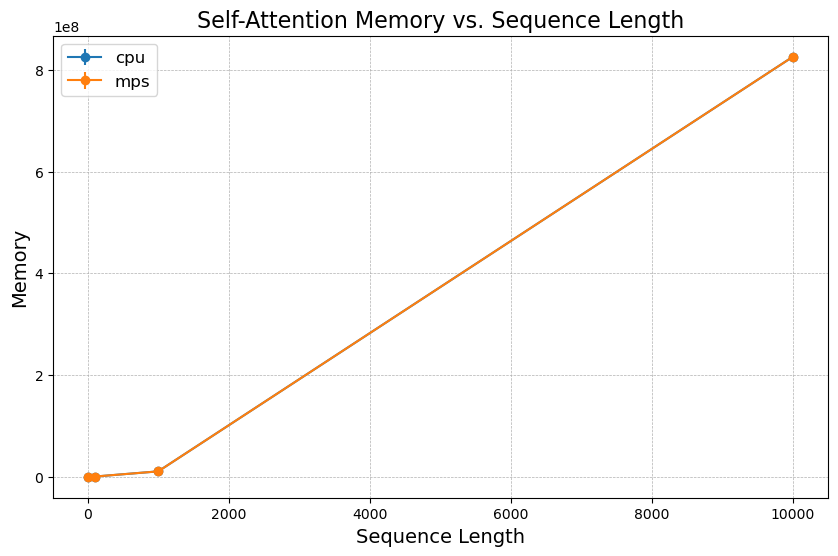

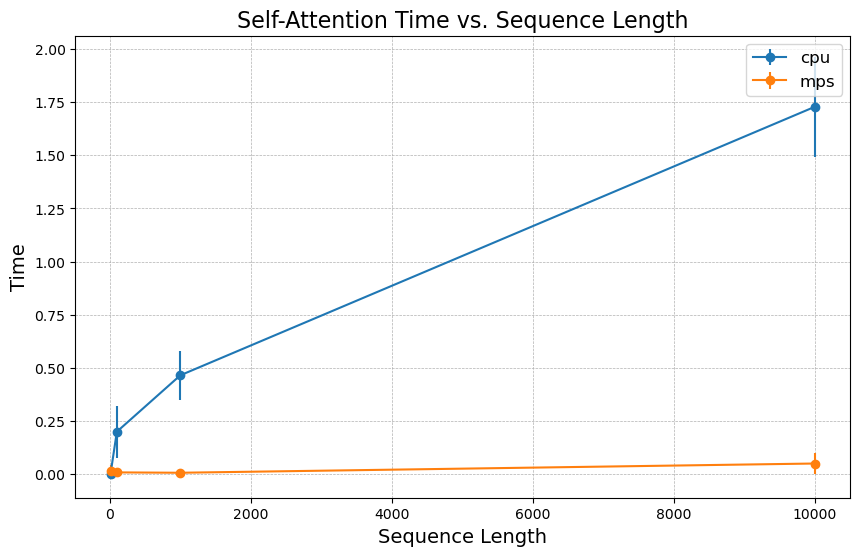

In [19]:
# plot results
import matplotlib.pyplot as plt

# plot both devices at onc
for metric_idx, metric_name in enumerate(['FLOPS', 'Memory', 'Time']):
    plt.figure(figsize=(10, 6))
    for device in devices:
        metric_values = []
        metric_stds = []
        for length_idx in range(len(lengths)): 
            runs_for_length = results[device.type][length_idx]
            values = [run[metric_idx] for run in runs_for_length]
            metric_values.append(np.mean(values))
            metric_stds.append(np.std(values))
        
        plt.errorbar(lengths, metric_values, yerr=metric_stds, fmt='o-', label=device.type)
    
    plt.xlabel('Sequence Length', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f'Self-Attention {metric_name} vs. Sequence Length', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()